# Introduction to Support Vector Machines with a Trading Example

This notebook is about how to implement a Support Vector Machines model in a financial markets example, taken from [this blog post on 'Towards Data Science'](https://towardsdatascience.com/intro-to-support-vector-machines-with-a-trading-example-1d4a7997ced6).

In [1]:
from bs4 import BeautifulSoup
import datetime, json
import numpy as np
import pandas as pd
import requests, time, warnings
warnings.simplefilter('ignore')

In [2]:
# requires the TA-lib package
import talib as ta
from talib import MA_Type

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm

In [4]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

In [5]:
Dow_Page = requests.get('https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI')
Dow_Content = Dow_Page.content

In [6]:
soup = BeautifulSoup(Dow_Content)
data = list(soup.findAll("td",{"class":"Py(10px) Ta(start) Pend(10px)"}))

In [7]:
Ticker_List = []
for i in data:
    TempData = str(i)
    if "title" in TempData:
        TempData = TempData[TempData.find("title"):]
        TempData = TempData[TempData.find(">")+1:TempData.find("<")]
        Ticker_List.append(TempData)
    else:
        continue

In [8]:
Start_Date = int(time.mktime((2014,10,28,4,0,0,0,0,0)))
End_Date = int(time.mktime((2019,10,28,4,0,0,0,0,0)))

In [9]:
def ScrapeYahoo(data_df,ticker, start, end):
    # form the URL to be scraped
    Base_Url = 'https://query1.finance.yahoo.com/v8/finance/chart/'
    Scrape_Url = Base_Url + ticker + "?period1=" + str(start)+"&period2="+str(end)+"&interval=1d"
    # get data from page
    r = requests.get(Scrape_Url)
    Page_Data = r.json()
    # compile data into a DataFrame
    Stock_df = pd.DataFrame()
    Stock_df['DateTime'] = Page_Data['chart']['result'][0]['timestamp']
    Stock_df['DateTime'] = Stock_df['DateTime'].apply(lambda x: datetime.datetime.fromtimestamp(x).date().isoformat())
    Stock_df["Open"] = Page_Data["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    Stock_df["High"] = Page_Data["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    Stock_df["Low"] = Page_Data["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    Stock_df["Close"] = Page_Data["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    Stock_df["Volume"] = Page_Data["chart"]["result"][0]["indicators"]["quote"][0]["volume"]
    Stock_df = Stock_df.set_index("DateTime")
    # add data to a dictionary containing all values
    data_df[ticker] =  Stock_df

In [10]:
Stock_Data = {}
for i in Ticker_List:
    ScrapeYahoo(Stock_Data, i, Start_Date, End_Date)
#     print(i + " done")
#     time.sleep(0.5)

In [11]:
for i in Ticker_List:
    Stock_Data[i]['High Shifted'] = Stock_Data[i]['High'].shift(-1)
    Stock_Data[i]['Low Shifted'] = Stock_Data[i]['Low'].shift(-1)
    Stock_Data[i]['Close Shifted'] = Stock_Data[i]['Close'].shift(-1)
    Stock_Data[i]['Upper BBand'], Stock_Data[i]['Middle BBand'],Stock_Data[i]['Lower BBand']= ta.BBANDS(Stock_Data[i]['Close Shifted'], timeperiod=20,)
    Stock_Data[i]['RSI'] = ta.RSI(np.array(Stock_Data[i]['Close Shifted']), timeperiod=14)
    Stock_Data[i]['Macd'], Stock_Data[i]['Macd Signal'],Stock_Data[i]['Macd Hist'] = ta.MACD(Stock_Data[i]['Close Shifted'], \
                                                                                             fastperiod=12, slowperiod=26, signalperiod=9)
    Stock_Data[i]['Momentum'] = ta.MOM(Stock_Data[i]['Close Shifted'],timeperiod=12)
    Stock_Data[i]['Returns'] = np.log(Stock_Data[i]['Open']/Stock_Data[i]['Open'].shift(-1))

In [12]:
for i in Ticker_List:
    Signal_List = []
    for j in Stock_Data[i]['Returns']:
        if (j>=0):
            Signal_List.append("1")
        else:
            Signal_List.append("0")
    Stock_Data[i]['Signal'] = Signal_List

In [13]:
max_abs_scaler = preprocessing.MaxAbsScaler()

Model_Dict = {}

for i in Ticker_List:
    Stock_Data[i].dropna(inplace=True)
    X = np.array(Stock_Data[i].drop(['Signal','Returns'],1))
    X = max_abs_scaler.fit_transform(X)
    Y = np.array(Stock_Data[i]['Signal'])
    # split into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    # model dictionary
    Model_Dict[i] = {}
    Model_Dict[i]['X Train'] = X_train
    Model_Dict[i]['X Test'] = X_test
    Model_Dict[i]['Y Train'] = y_train
    Model_Dict[i]['Y Test'] = y_test
    # models
    # model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    model = svm.SVC(kernel='linear')
    #model = svm.SVC(kernel='linear',decision_function_shape='ovo')
    #model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    #model = svm.SVC(kernel='poly')
    #model = svm.SVC(kernel='poly',decision_function_shape='ovo')
    #model = svm.SVC(kernel='sigmoid')
    #model = svm.SVC(kernel='sigmoid',decision_function_shape='ovo')
    
    model.fit(Model_Dict[i]['X Train'], Model_Dict[i]['Y Train'])
    y_pred = model.predict(Model_Dict[i]['X Test'])
    # prediction column
    Model_Dict[i]['Y Prediction'] = y_pred
    # results
    print("SVM Model Info for Ticker: "+i)
    print("Accuracy:",metrics.accuracy_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction']))
    Model_Dict[i]['Accuracy'] = metrics.accuracy_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'])
    print("Precision:",metrics.precision_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
    Model_Dict[i]['Precision'] = metrics.precision_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro")
    print("Recall:",metrics.recall_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
    Model_Dict[i]['Recall'] = metrics.recall_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro")
    print("#################### \n")

SVM Model Info for Ticker: MSFT
Accuracy: 0.6277173913043478
Precision: 0.6441044776119403
Recall: 0.6144805098562325
#################### 

SVM Model Info for Ticker: VZ
Accuracy: 0.6793478260869565
Precision: 0.6846153846153846
Recall: 0.6816676522767593
#################### 

SVM Model Info for Ticker: CVX
Accuracy: 0.6195652173913043
Precision: 0.6165137614678899
Recall: 0.6131907308377897
#################### 

SVM Model Info for Ticker: NKE
Accuracy: 0.6657608695652174
Precision: 0.6659125188536953
Recall: 0.6598837209302326
#################### 

SVM Model Info for Ticker: WMT
Accuracy: 0.6032608695652174
Precision: 0.6032730710150065
Recall: 0.6032608695652174
#################### 

SVM Model Info for Ticker: INTC
Accuracy: 0.6141304347826086
Precision: 0.6108751062022091
Recall: 0.6085561497326203
#################### 

SVM Model Info for Ticker: JNJ
Accuracy: 0.657608695652174
Precision: 0.65663131148994
Recall: 0.6590752242926157
#################### 

SVM Model Info for Tic

In [14]:
for i in Ticker_List:
    
    prediction_length = len(Model_Dict[i]['Y Prediction'])
    
    Stock_Data[i]['SVM Signal'] = 0
    Stock_Data[i]['SVM Returns'] = 0
    Stock_Data[i]['Total Strat Returns'] = 0
    Stock_Data[i]['Market Returns'] = 0
    
    Signal_Column = Stock_Data[i].columns.get_loc('SVM Signal')
    Strat_Column = Stock_Data[i].columns.get_loc('SVM Returns')
    Return_Column = Stock_Data[i].columns.get_loc('Total Strat Returns')
    Market_Column = Stock_Data[i].columns.get_loc('Market Returns')
       
    Stock_Data[i].iloc[-prediction_length:,Signal_Column] = list(map(int,Model_Dict[i]['Y Prediction']))
    Stock_Data[i]['SVM Returns'] = Stock_Data[i]['SVM Signal'] * Stock_Data[i]['Returns'].shift(-1)
    
    Stock_Data[i].iloc[-prediction_length:,Return_Column] = np.nancumsum(Stock_Data[i]['SVM Returns'][-prediction_length:])
    Stock_Data[i].iloc[-prediction_length:,Market_Column] = np.nancumsum(Stock_Data[i]['Returns'][-prediction_length:])
    
    Model_Dict[i]['Sharpe_Ratio'] = (Stock_Data[i]['Total Strat Returns'][-1] - Stock_Data[i]['Market Returns'][-1])/ \
    np.nanstd(Stock_Data[i]['Total Strat Returns'][-prediction_length:])

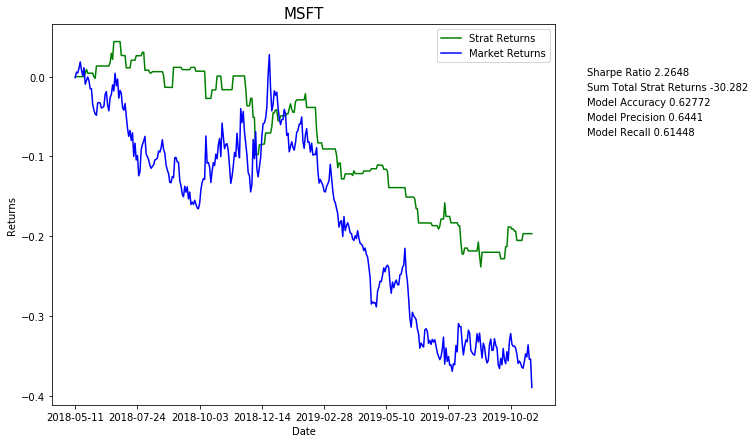

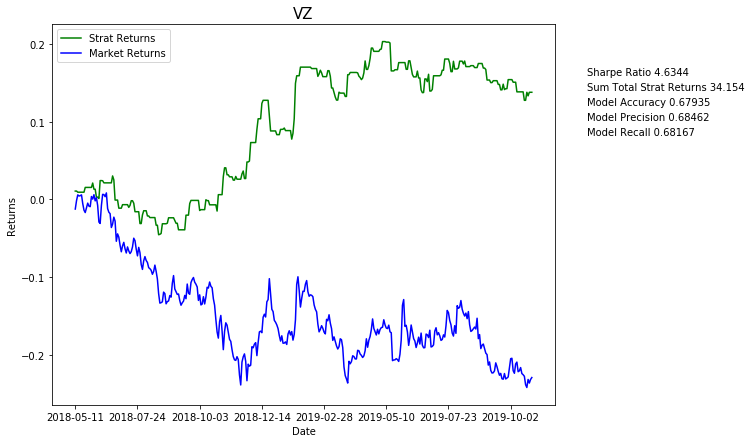

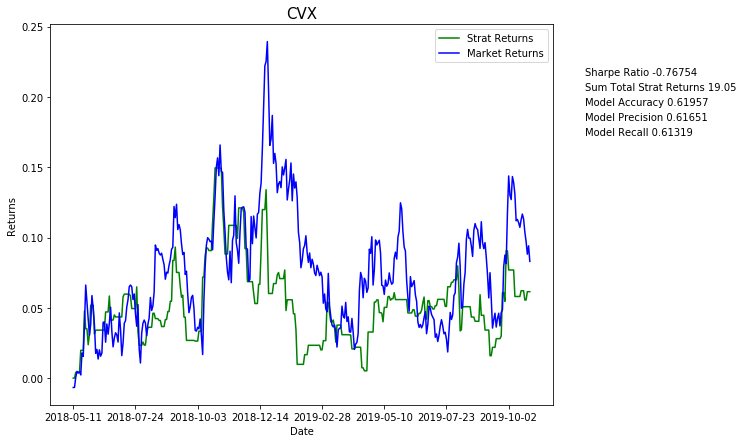

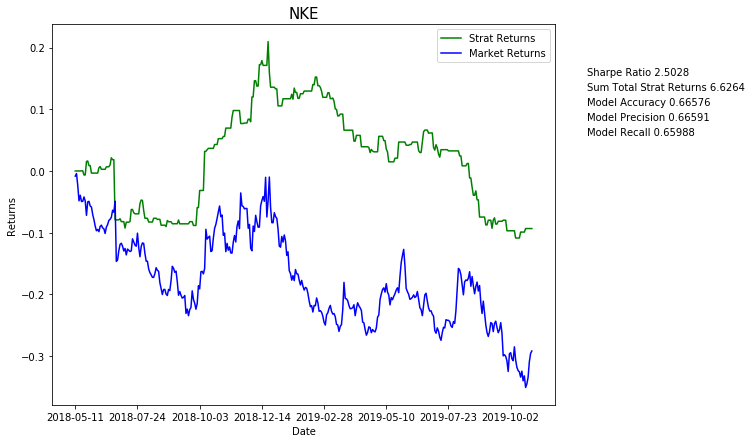

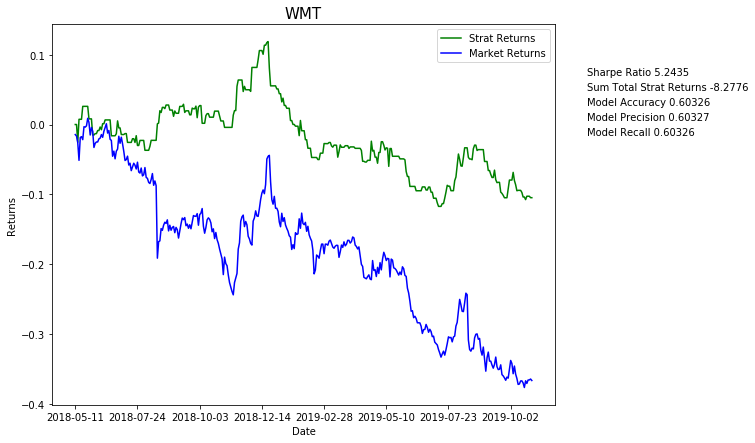

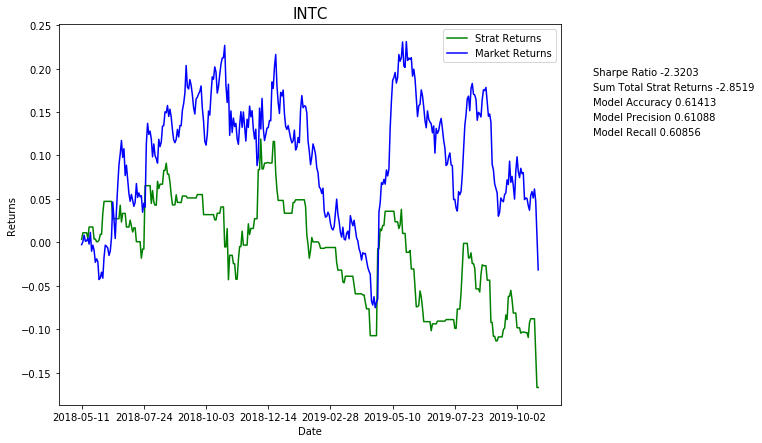

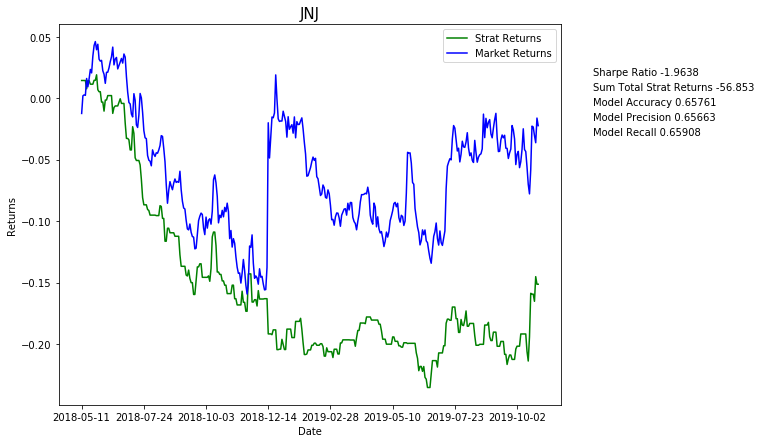

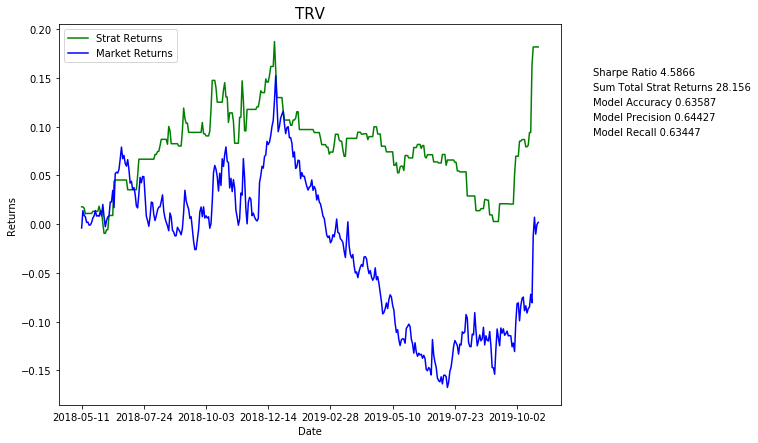

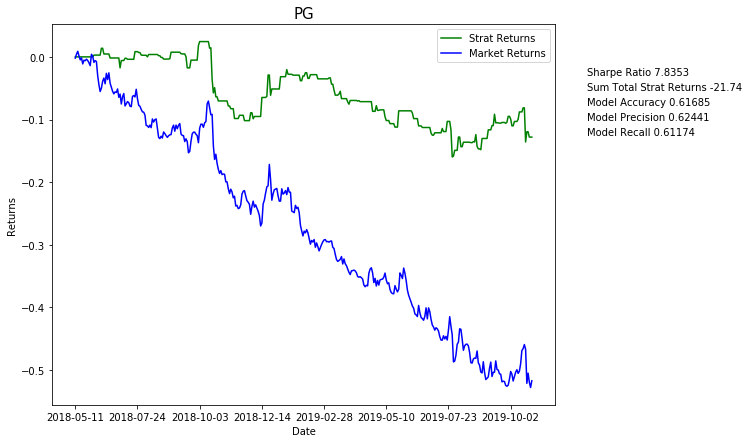

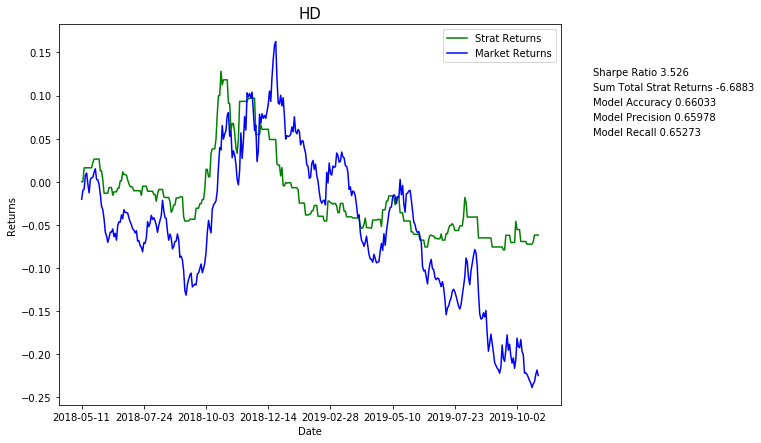

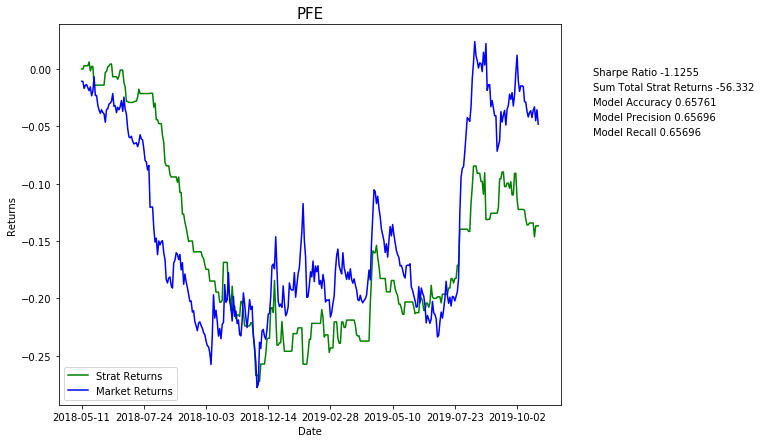

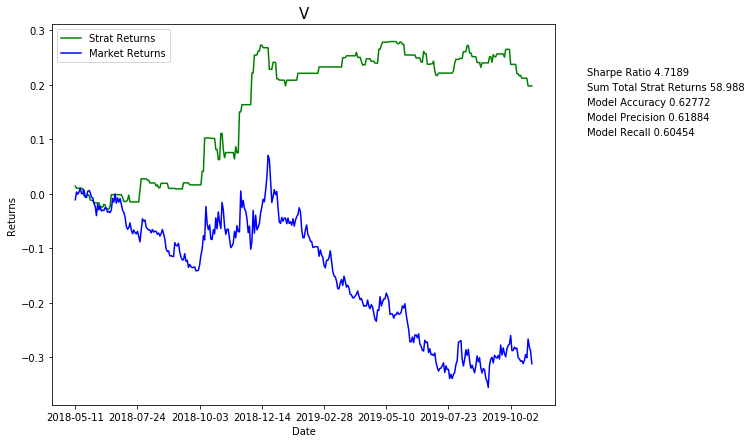

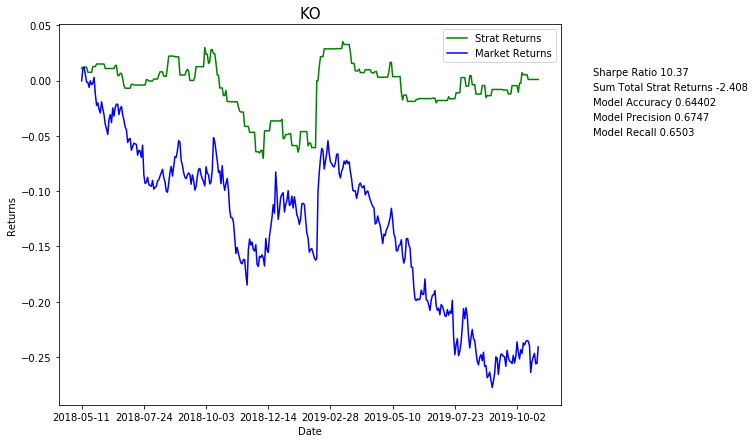

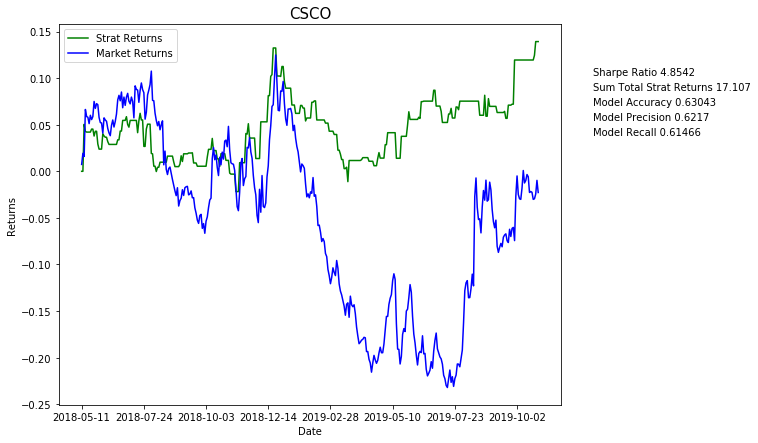

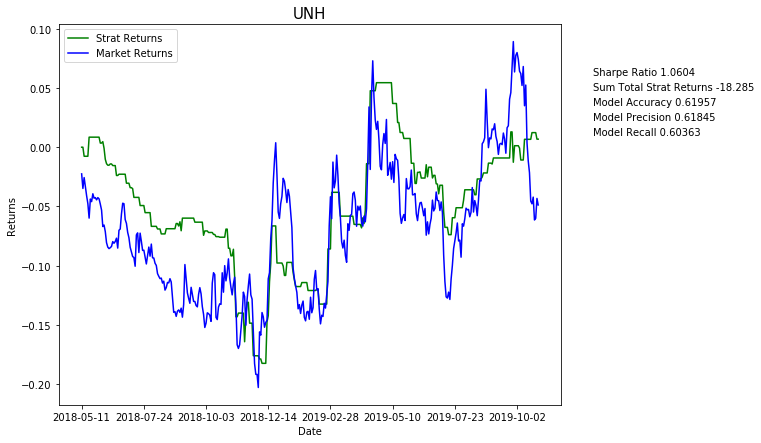

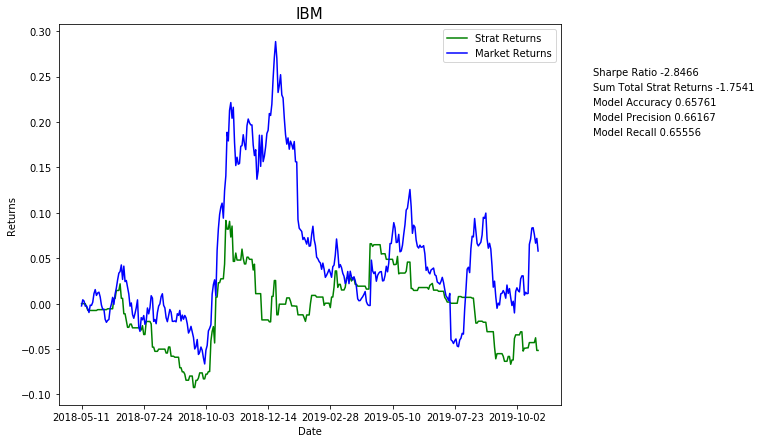

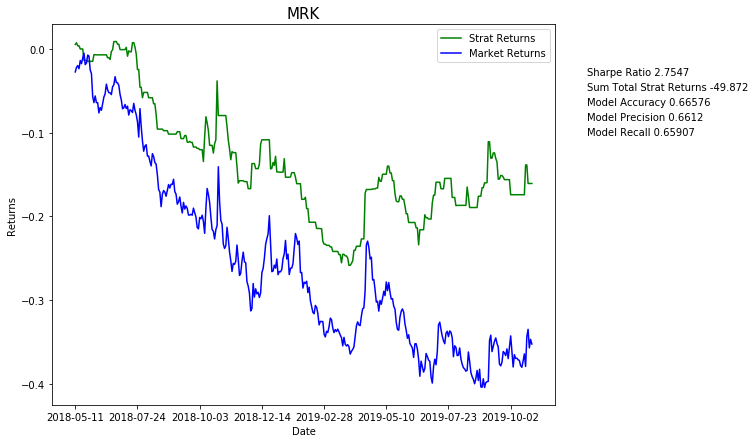

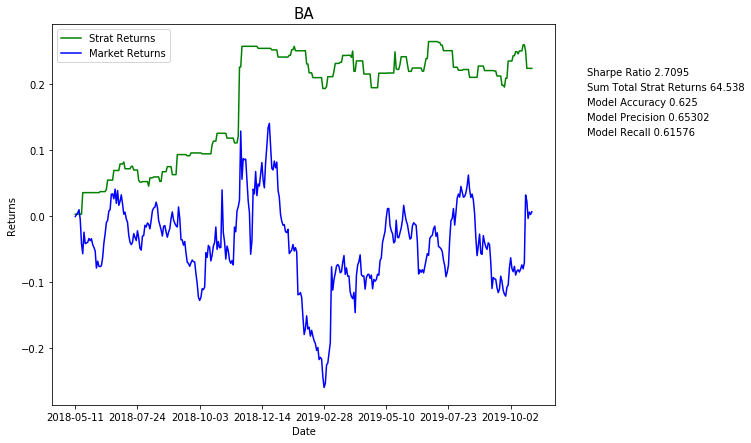

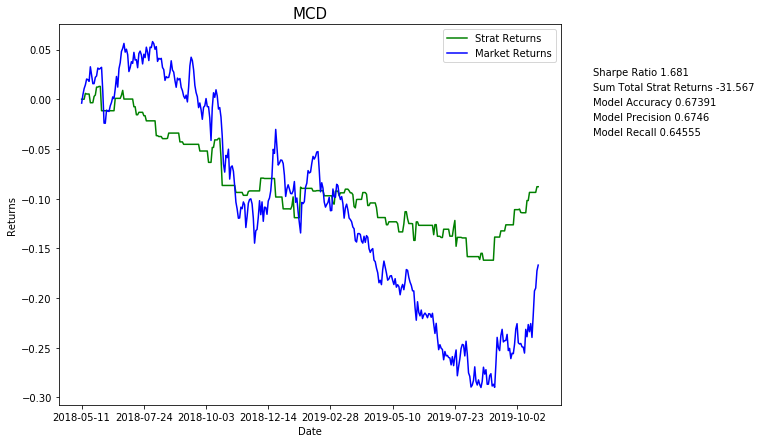

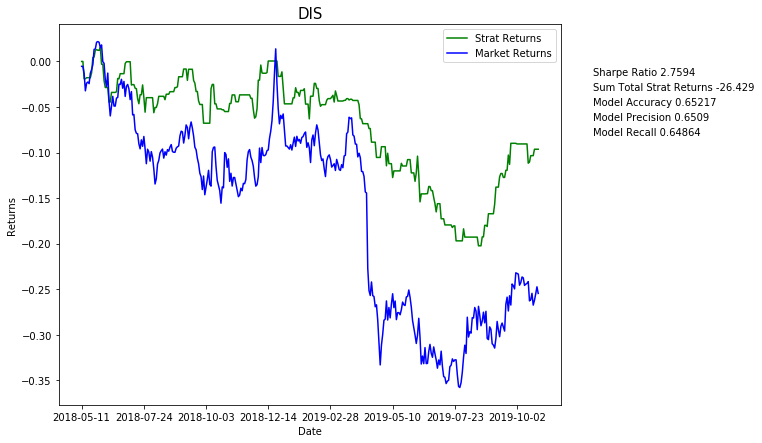

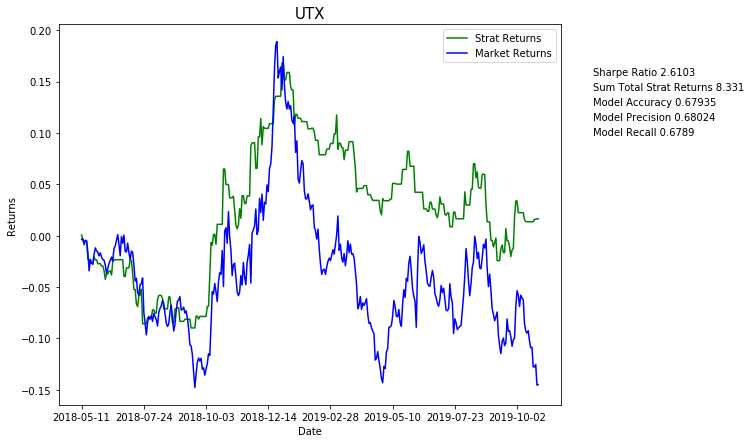

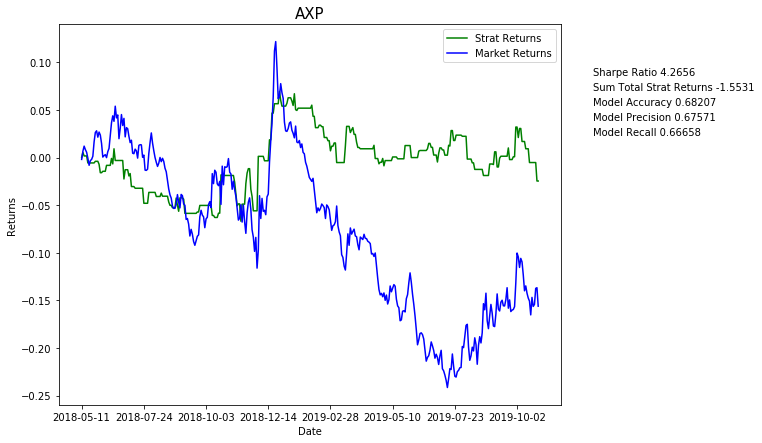

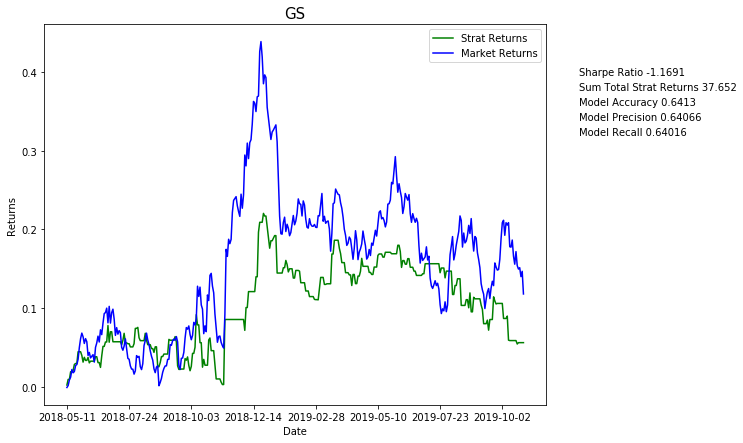

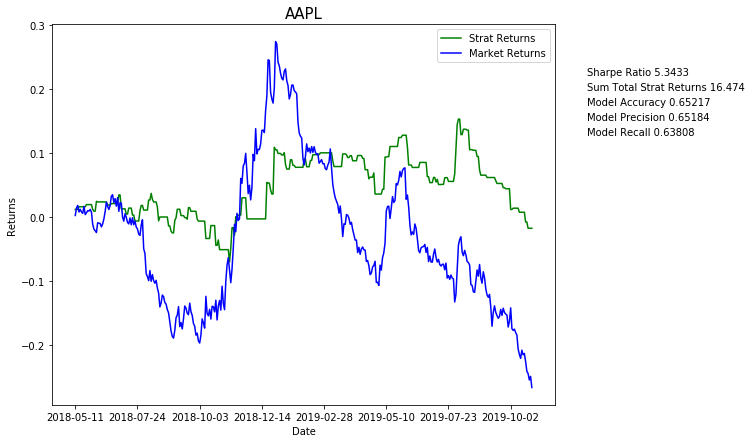

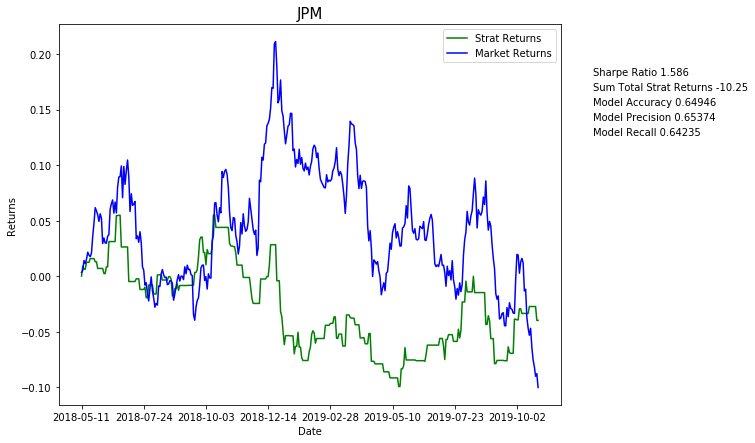

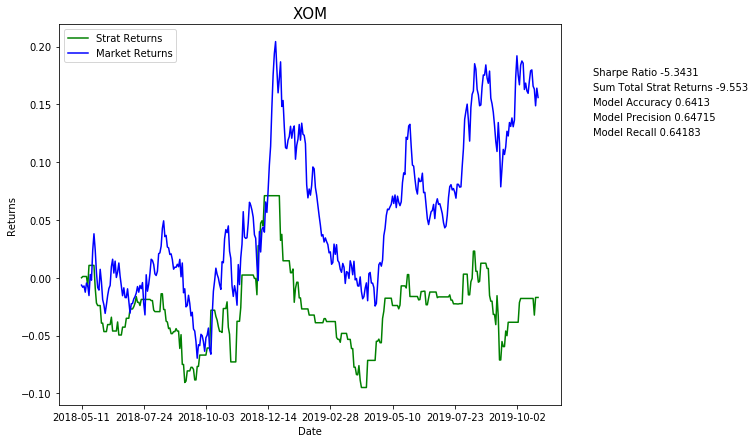

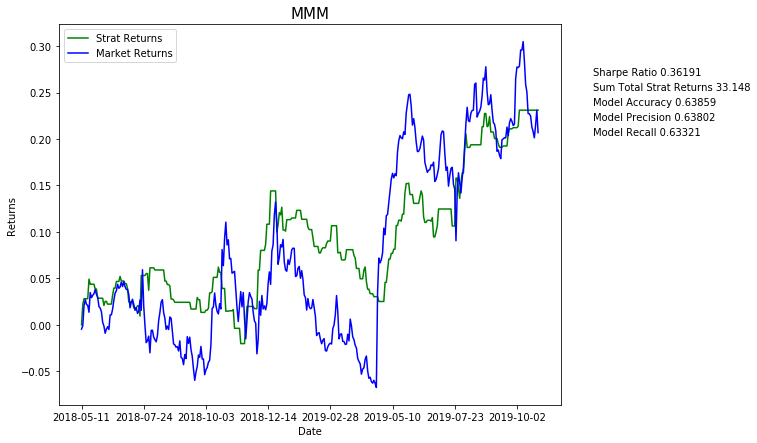

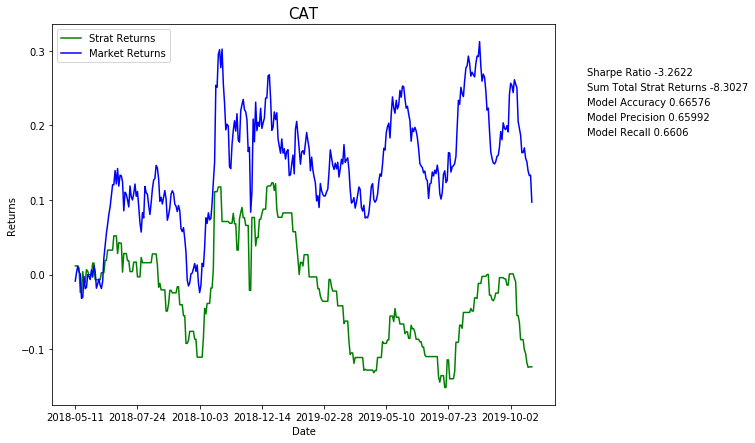

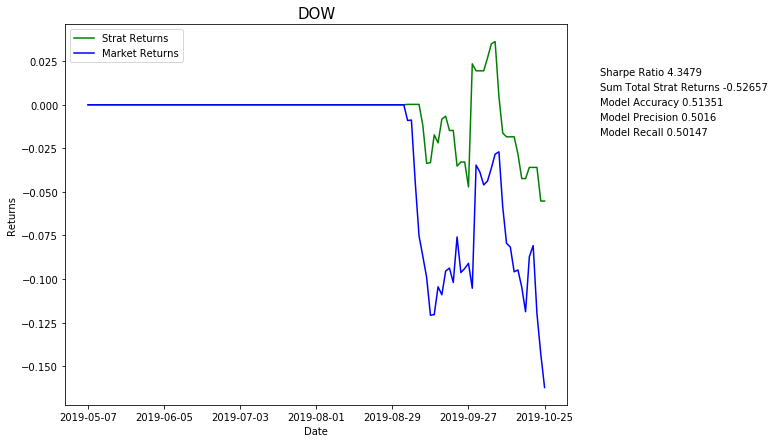

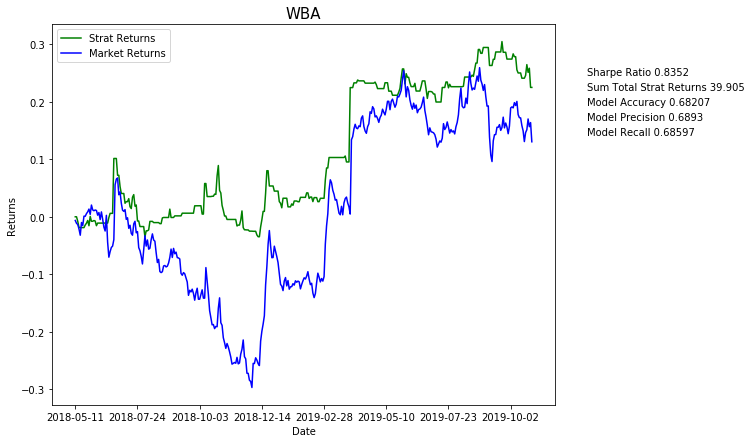

In [15]:
for i in Ticker_List:
    fig, ax = plt.subplots(figsize=(9, 7))

    ax.plot(Stock_Data[i][-prediction_length:].index.values,
            Stock_Data[i]['Total Strat Returns'][-prediction_length:].values, color='g', label="Strat Returns")
    
    ax.plot(Stock_Data[i][-prediction_length:].index.values,
            Stock_Data[i]['Market Returns'][-prediction_length:].values, color='b', label="Market Returns")
    
    ax.set(xlabel= "Date",ylabel="Returns")
    plt.title(i,fontsize=15)
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    
    plt.figtext(.95,0.78, s="Sharpe Ratio "+'{0:.5g}'.format(Model_Dict[i]['Sharpe_Ratio']))
    plt.figtext(.95,0.75, s="Sum Total Strat Returns "+'{0:.5g}'.format(Stock_Data[i]['Total Strat Returns'].sum()))
    plt.figtext(.95,0.72,s="Model Accuracy " +'{0:.5g}'.format(Model_Dict[i]['Accuracy']))
    plt.figtext(.95,0.69,s="Model Precision " +'{0:.5g}'.format(Model_Dict[i]['Precision']))
    plt.figtext(.95,0.66,s="Model Recall " +'{0:.5g}'.format(Model_Dict[i]['Recall']))
    
    plt.legend(loc='best')
    plt.show()